# Basic imports and obtaining datasets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("../..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-10-04 10:55:03.354514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-04 10:55:03.354533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../../data/views/KuHar/resampled_view_20Hz")

In [4]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

In [5]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Transforming KuHar to 20Hz

In [6]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [7]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

In [8]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [9]:
print(train_dataset_fft.X.shape)
print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3330, 180)
(108, 180)
(378, 180)


# Applying topological autoencoders

In [10]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

dimensions = [5, 6, 7, 8, 9]
topo_models = []
lowdim_test_dataset_fft = []
lowdim_train_dataset_fft = []
lowdim_pyDRMetrics_eval = []
lowdim_classification_eval = []


In [11]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=True, use_confusion_matrix=True, plot_confusion_matrix=True)

# experiment3 = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
# multi_run_experiment = MultiRunWorkflow(workflow=experiment1, num_runs=10, debug=False)

def print_results(results):
    mean_acc = np.average(
        [res["result"][0]["accuracy"] for res in results["runs"]]
    )

    std_acc = np.std(
        [res["result"][0]["accuracy"] for res in results["runs"]]
    )

    mean_f1 = np.average(
        [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
    )
    std_f1 = np.std(
        [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
    )

    print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (1 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")
def eval_RF(train_dset, test_dset):
    experiment = SimpleTrainEvalWorkflow(
        estimator=RandomForestClassifier,
        do_not_instantiate=False,
        do_fit=True,
        evaluator=reporter
    )
    multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
    results = multi_run_experiment(train_dset, test_dset)
    print_results(results)

def eval_SVC(train_dset, test_dset):
    experiment = SimpleTrainEvalWorkflow(
        estimator=SVC,
        do_not_instantiate=False,
        do_fit=True,
        evaluator=reporter,
    )
    multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
    results = multi_run_experiment(train_dset, test_dset)
    print_results(results)

def eval_KNN(train_dset, test_dset):
    experiment = SimpleTrainEvalWorkflow(
        estimator=KNeighborsClassifier,
        do_not_instantiate=False,
        do_fit=True,
        evaluator=reporter,
    )
    multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
    results = multi_run_experiment(train_dset, test_dset)
    print_results(results)
    
def get_classification_metrics(train_x, train_y, test_x, test_y):
    train_x_pd = pd.DataFrame(train_x)
    train_x_pd['y'] = train_y
    train_dset = PandasMultiModalDataset(
        train_x_pd,
        label_columns="y",
        as_array=True
    )

    test_x_pd = pd.DataFrame(test_x)
    test_x_pd['y'] = test_y
    test_dset = PandasMultiModalDataset(
        test_x_pd,
        label_columns="y",
        as_array=True
    )

    eval_RF(train_dset, test_dset)
    eval_SVC(train_dset, test_dset)
    eval_KNN(train_dset, test_dset)
# result = multi_run_experiment(combined_train_dset, test_dataset)
# print(yaml.dump(result, sort_keys=True, indent=4))

In [12]:
print(test_dataset_fft.X.shape, test_dataset_fft.X.shape)

(378, 180) (378, 180)


In [13]:
# print(test_dataset_after_topoae_transform.shape)

In [14]:
# print(train_dataset_after_topoae_transform.shape)

START DIMENSION 5
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 5
Epoch:1, P:10, Loss:335.2188, Loss-ae:317.0961, Loss-topo:18.1226
Epoch:2, P:10, Loss:283.5940, Loss-ae:257.2050, Loss-topo:26.3890
Epoch:3, P:10, Loss:259.8122, Loss-ae:250.7505, Loss-topo:9.0617
Epoch:4, P:10, Loss:229.9096, Loss-ae:224.3996, Loss-topo:5.5100
Epoch:5, P:10, Loss:240.3954, Loss-ae:236.0170, Loss-topo:4.3784
Epoch:6, P:9, Loss:237.5321, Loss-ae:232.8936, Loss-topo:4.6385
Epoch:7, P:8, Loss:247.9574, Loss-ae:243.2805, Loss-topo:4.6769
Epoch:8, P:7, Loss:279.0799, Loss-ae:275.6888, Loss-topo:3.3912
Epoch:9, P:6, Loss:230.3408, Loss-ae:227.0028, Loss-topo:3.3379
Epoch:10, P:5, Loss:247.2664, Loss-ae:243.3913, Loss-topo:3.8751
Epoch:11, P:4, Loss:192.5465, Loss-ae:188.2317, Loss-topo:4.3148
Epoch:12, P:10, Loss:192.2263, Loss-ae:189.2375, Loss-topo:2.9889
Epoch:13, P:10, Loss:206.2665, Loss-ae:201.9312, Loss-topo:4.3353
Epoch:1

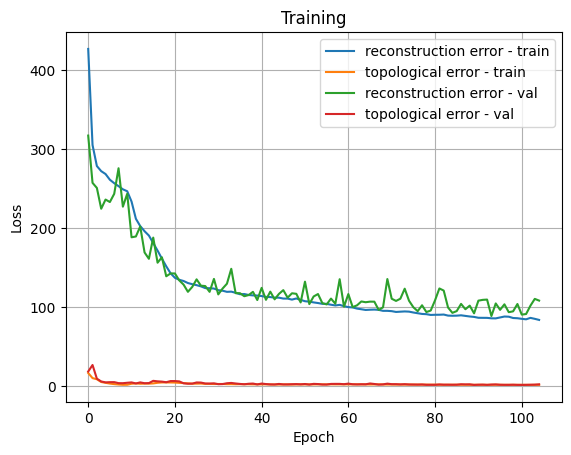

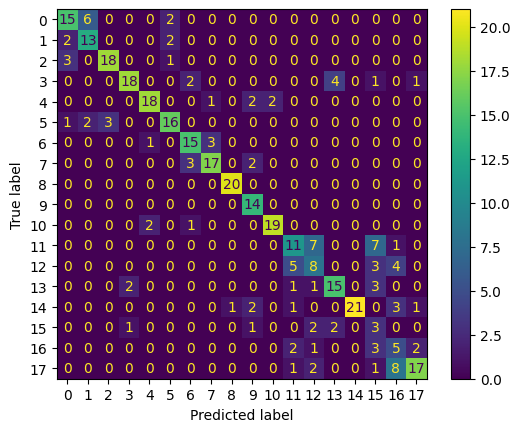

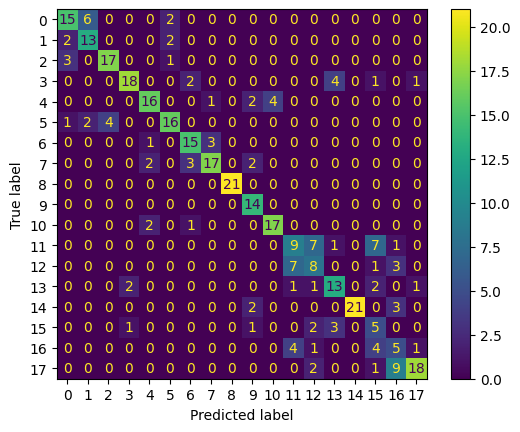

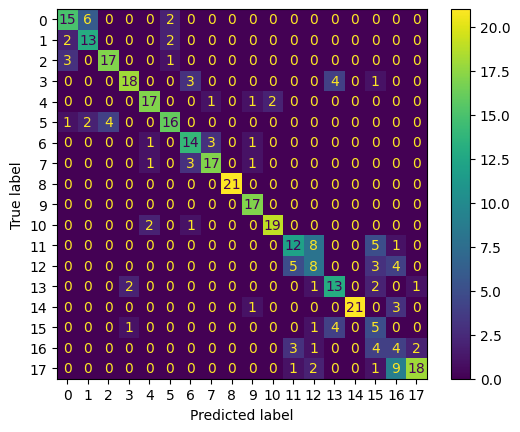

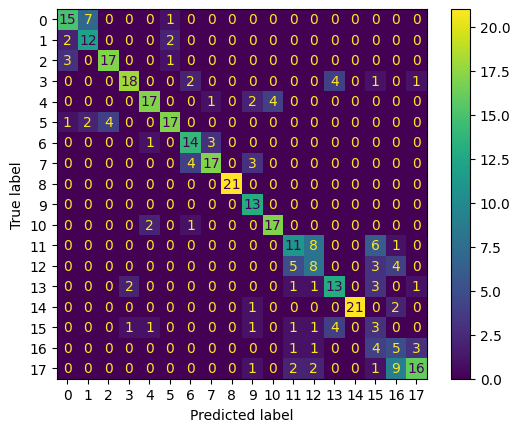

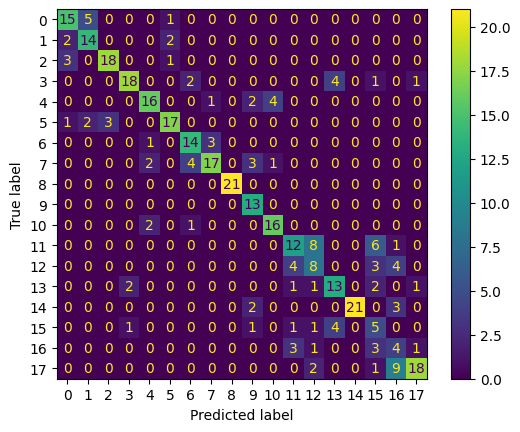

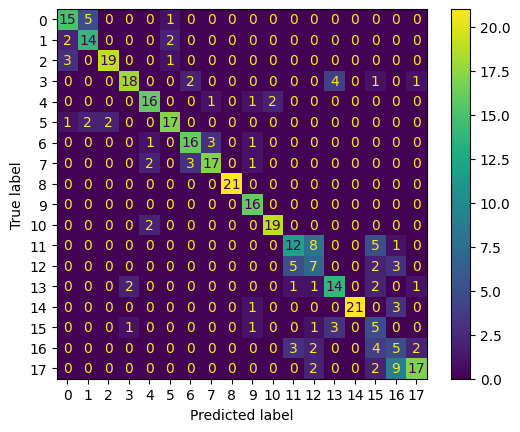

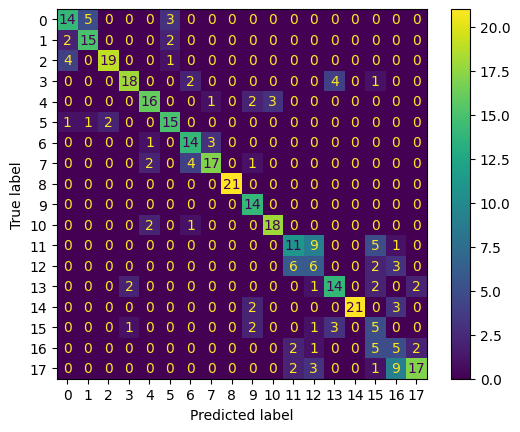

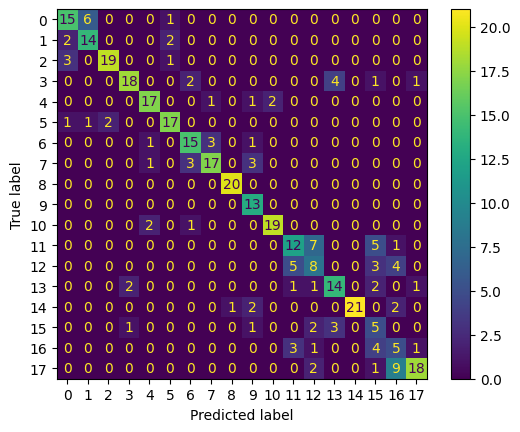

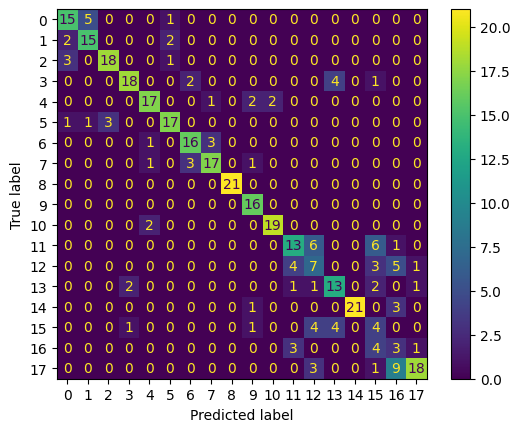

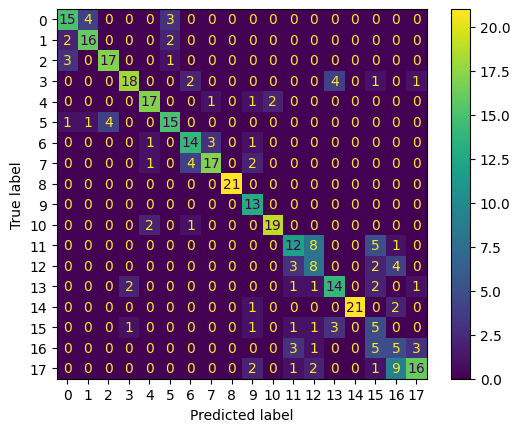

Mean accuracy (1 runs): 0.6952. Mean f1-score: 0.7048.Std accuracy (1 runs): 0.0115. Std f1-score: 0.0119


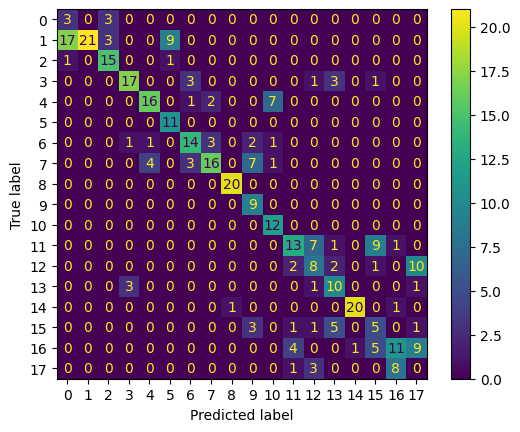

Mean accuracy (1 runs): 0.5847. Mean f1-score: 0.5954.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


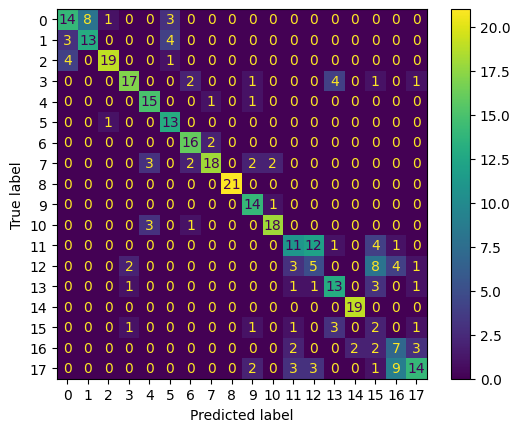

Mean accuracy (1 runs): 0.6587. Mean f1-score: 0.6615.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000
START DIMENSION 6
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 6
Epoch:1, P:10, Loss:397.7958, Loss-ae:365.3564, Loss-topo:32.4394
Epoch:2, P:10, Loss:256.5576, Loss-ae:251.0118, Loss-topo:5.5458
Epoch:3, P:10, Loss:268.9322, Loss-ae:262.2601, Loss-topo:6.6720
Epoch:4, P:9, Loss:280.9624, Loss-ae:272.3584, Loss-topo:8.6040
Epoch:5, P:8, Loss:257.9504, Loss-ae:254.8804, Loss-topo:3.0701
Epoch:6, P:7, Loss:231.9624, Loss-ae:229.6359, Loss-topo:2.3264
Epoch:7, P:10, Loss:259.5806, Loss-ae:256.6657, Loss-topo:2.9149
Epoch:8, P:9, Loss:254.5486, Loss-ae:251.9094, Loss-topo:2.6392
Epoch:9, P:8, Loss:207.5244, Loss-ae:205.8867, Loss-topo:1.6378
Epoch:10, P:10, Loss:230.5320, Loss-ae:223.8728, Loss-topo:6.6593
Epoch:11, P:9, Loss:195.1805, Loss-ae:192.0288, Loss-topo:3.1517
Epoch:12, P:10, Loss:171.1452, Los

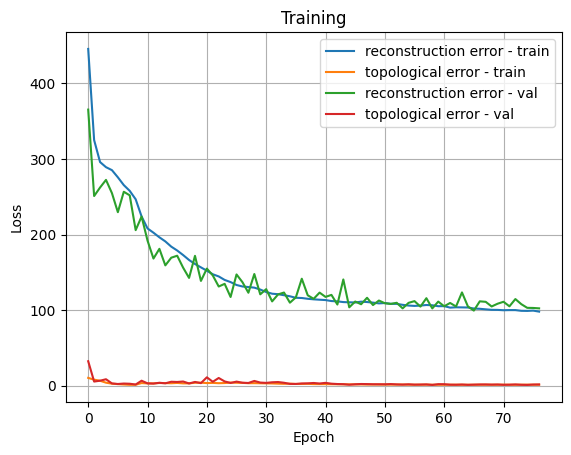

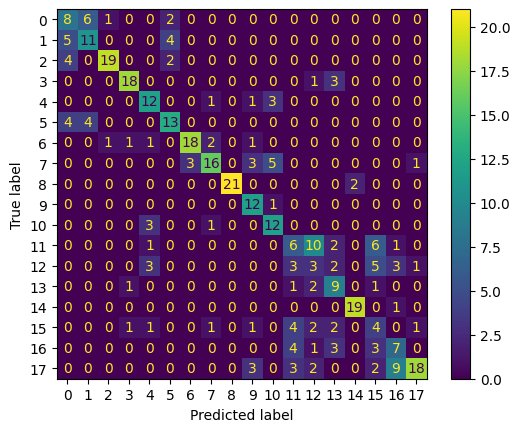

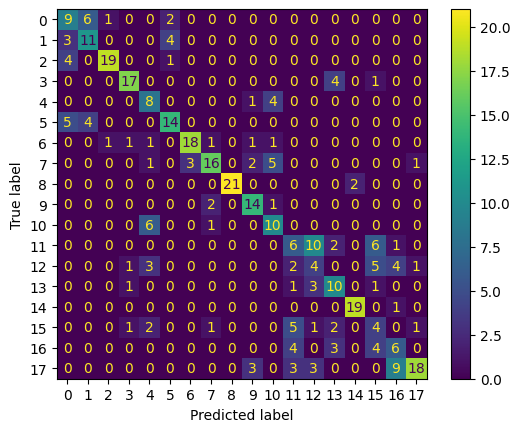

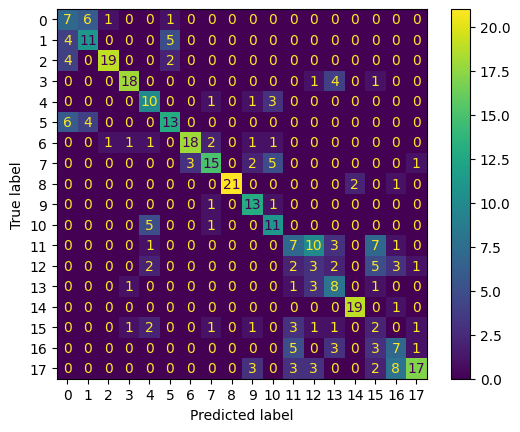

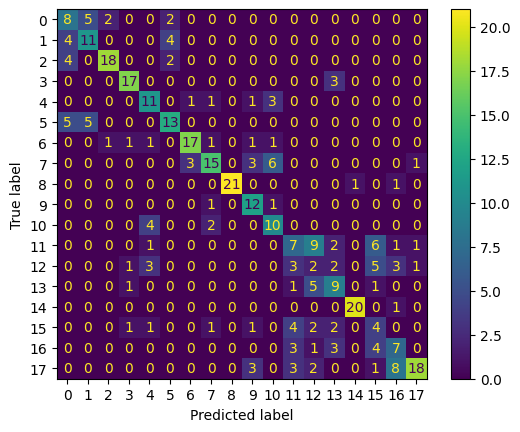

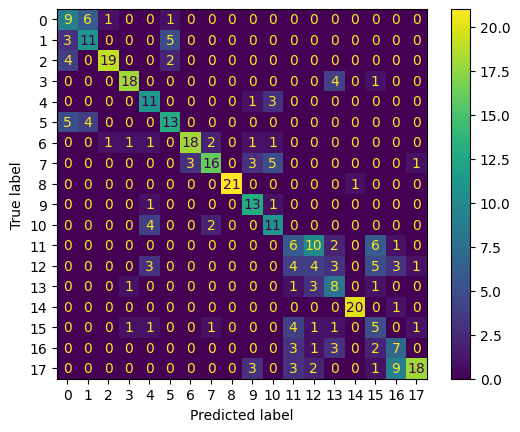

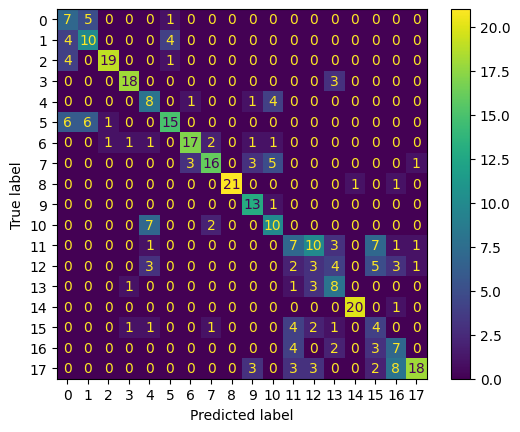

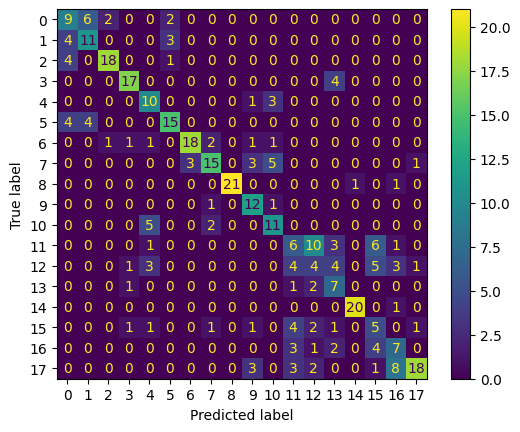

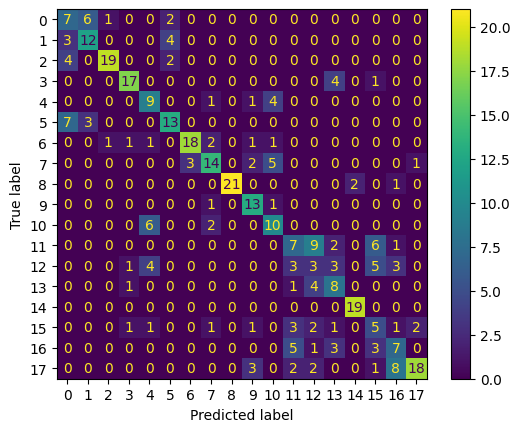

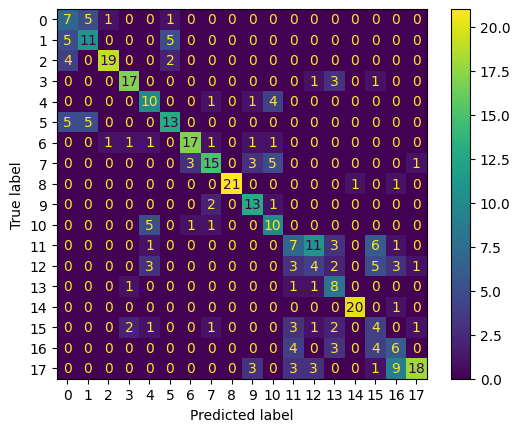

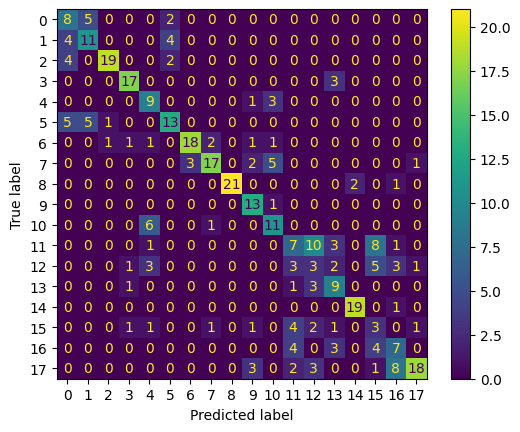

Mean accuracy (1 runs): 0.5886. Mean f1-score: 0.5957.Std accuracy (1 runs): 0.0075. Std f1-score: 0.0068


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


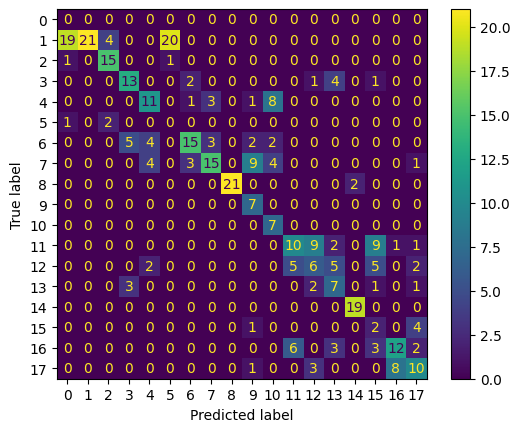

Mean accuracy (1 runs): 0.5053. Mean f1-score: 0.5352.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


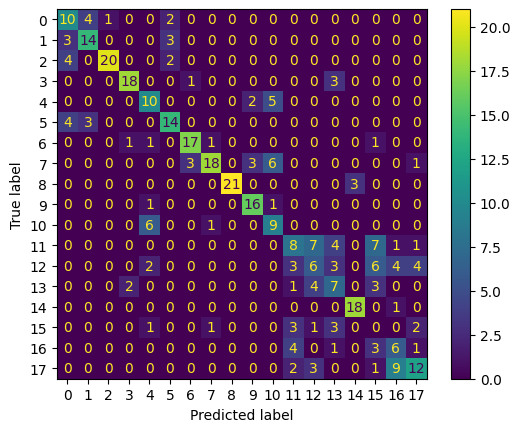

Mean accuracy (1 runs): 0.5926. Mean f1-score: 0.6015.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000
START DIMENSION 7
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 7
Epoch:1, P:10, Loss:356.3588, Loss-ae:327.9771, Loss-topo:28.3817
Epoch:2, P:10, Loss:255.2966, Loss-ae:247.5687, Loss-topo:7.7279
Epoch:3, P:10, Loss:250.0880, Loss-ae:238.9365, Loss-topo:11.1516
Epoch:4, P:10, Loss:271.4374, Loss-ae:254.4675, Loss-topo:16.9699
Epoch:5, P:9, Loss:237.8226, Loss-ae:234.7329, Loss-topo:3.0897
Epoch:6, P:10, Loss:243.3064, Loss-ae:241.2159, Loss-topo:2.0905
Epoch:7, P:9, Loss:234.7399, Loss-ae:230.8777, Loss-topo:3.8622
Epoch:8, P:10, Loss:215.3273, Loss-ae:213.9434, Loss-topo:1.3839
Epoch:9, P:10, Loss:224.2378, Loss-ae:222.3793, Loss-topo:1.8586
Epoch:10, P:9, Loss:237.8881, Loss-ae:234.9031, Loss-topo:2.9850
Epoch:11, P:8, Loss:203.1066, Loss-ae:198.6667, Loss-topo:4.4400
Epoch:12, P:10, Loss:234.2640,

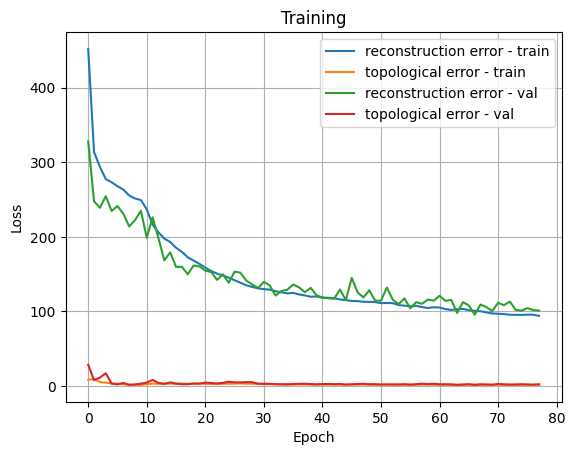

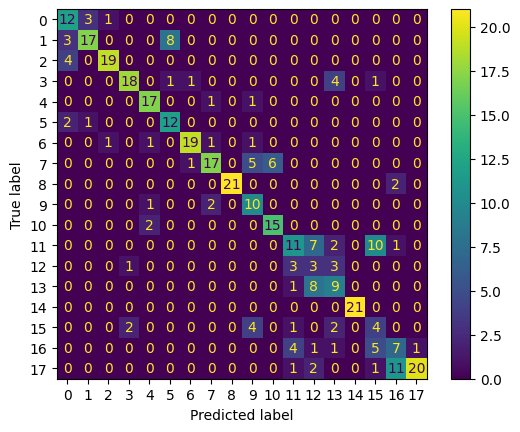

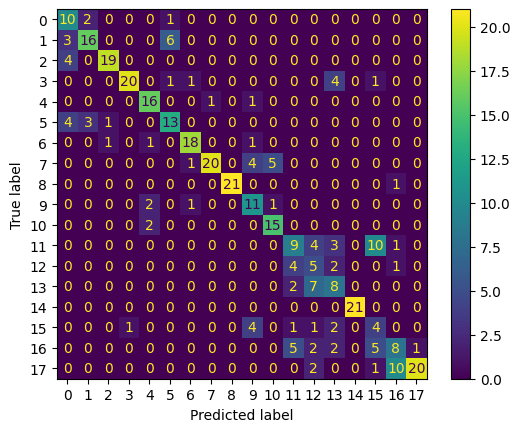

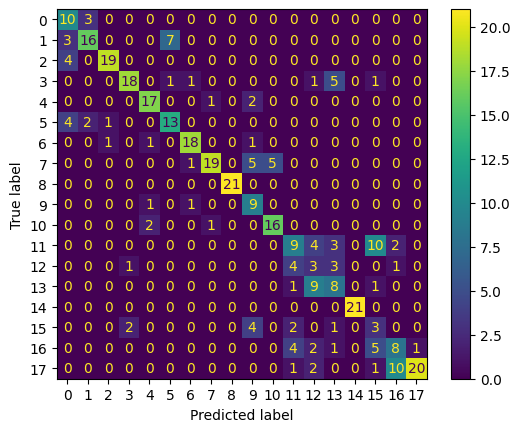

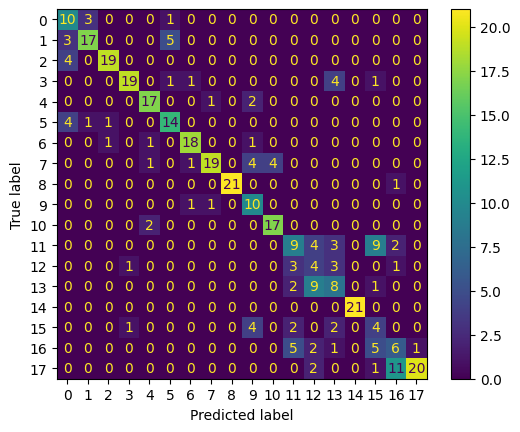

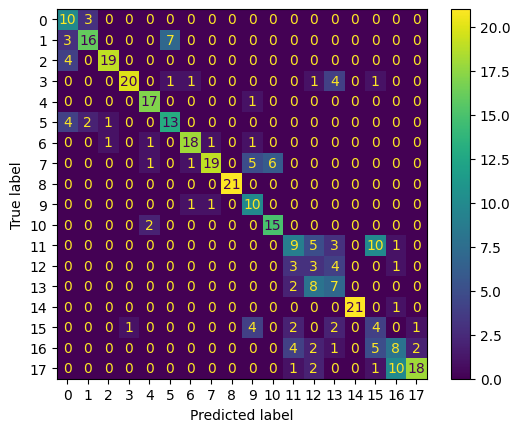

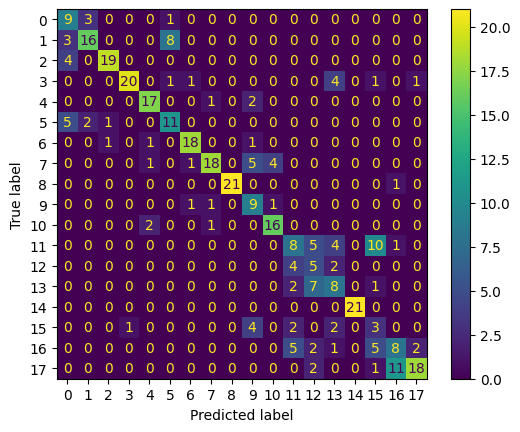

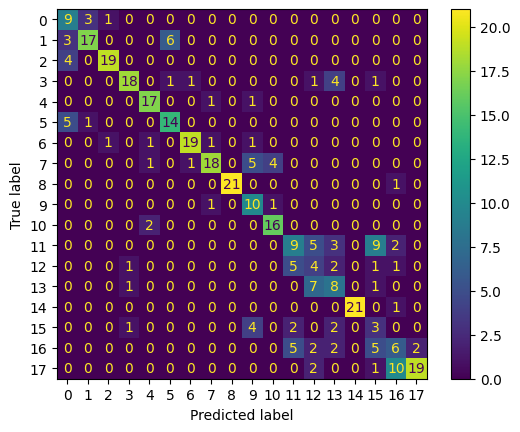

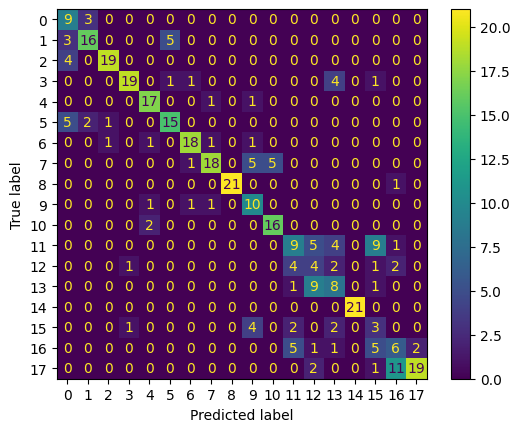

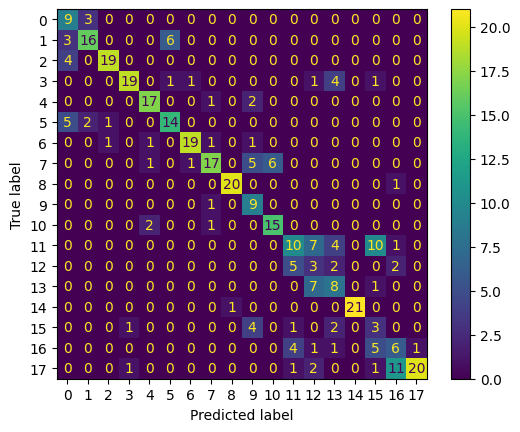

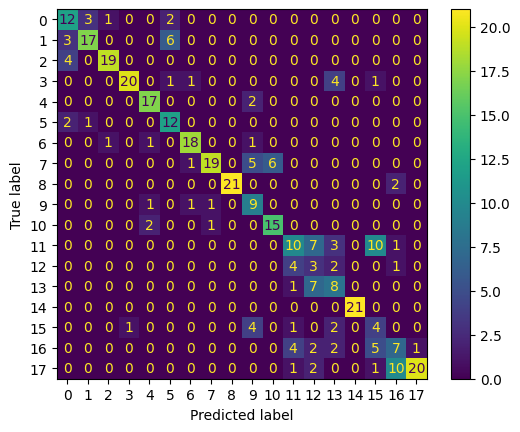

Mean accuracy (1 runs): 0.6595. Mean f1-score: 0.6732.Std accuracy (1 runs): 0.0081. Std f1-score: 0.0078


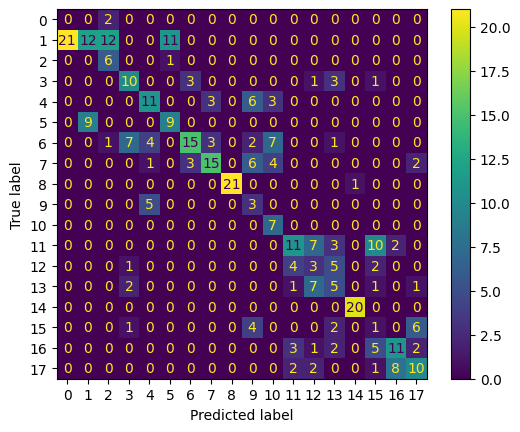

Mean accuracy (1 runs): 0.4497. Mean f1-score: 0.4672.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


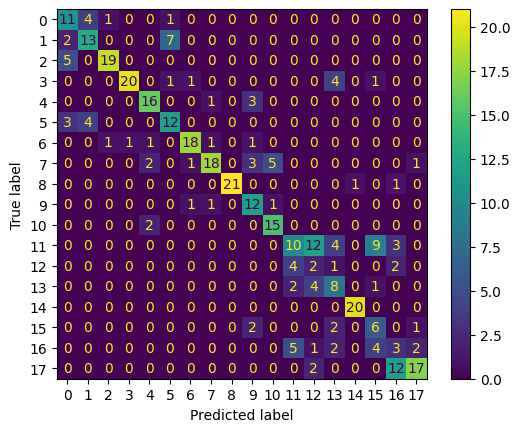

Mean accuracy (1 runs): 0.6376. Mean f1-score: 0.6498.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000
START DIMENSION 8
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 8
Epoch:1, P:10, Loss:410.4612, Loss-ae:348.7264, Loss-topo:61.7347
Epoch:2, P:10, Loss:280.1135, Loss-ae:273.8938, Loss-topo:6.2196
Epoch:3, P:10, Loss:277.5974, Loss-ae:268.0406, Loss-topo:9.5568
Epoch:4, P:10, Loss:270.0819, Loss-ae:266.7599, Loss-topo:3.3220
Epoch:5, P:10, Loss:308.9031, Loss-ae:304.7071, Loss-topo:4.1960
Epoch:6, P:9, Loss:244.1143, Loss-ae:243.1663, Loss-topo:0.9480
Epoch:7, P:10, Loss:279.9400, Loss-ae:276.9968, Loss-topo:2.9432
Epoch:8, P:9, Loss:230.7260, Loss-ae:229.9168, Loss-topo:0.8092
Epoch:9, P:10, Loss:218.1557, Loss-ae:217.1842, Loss-topo:0.9715
Epoch:10, P:10, Loss:203.3389, Loss-ae:201.1634, Loss-topo:2.1755
Epoch:11, P:10, Loss:205.2920, Loss-ae:202.1022, Loss-topo:3.1898
Epoch:12, P:9, Loss:192.7369, 

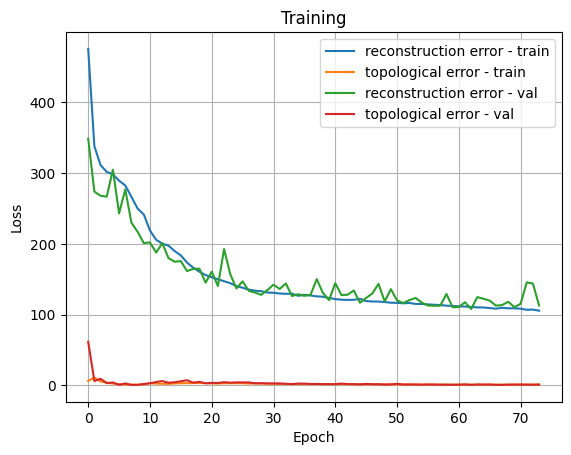

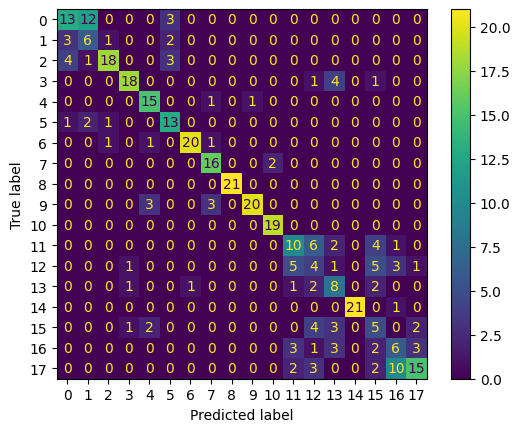

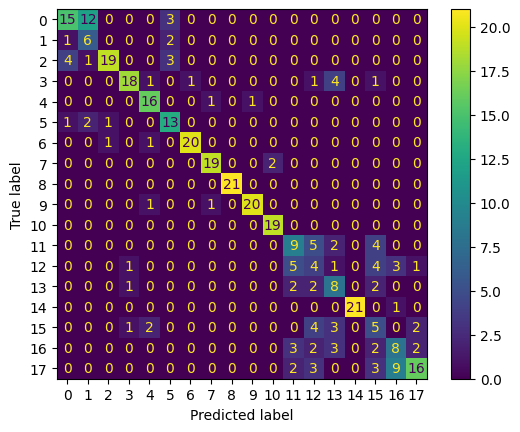

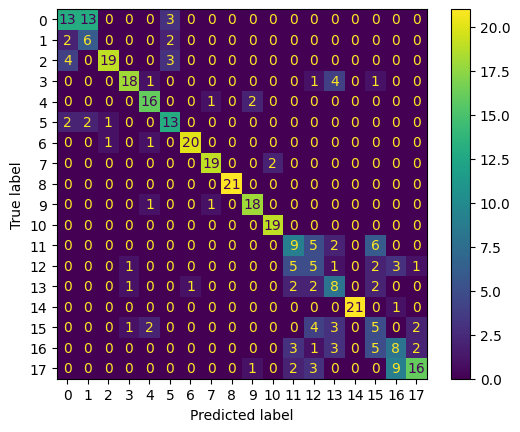

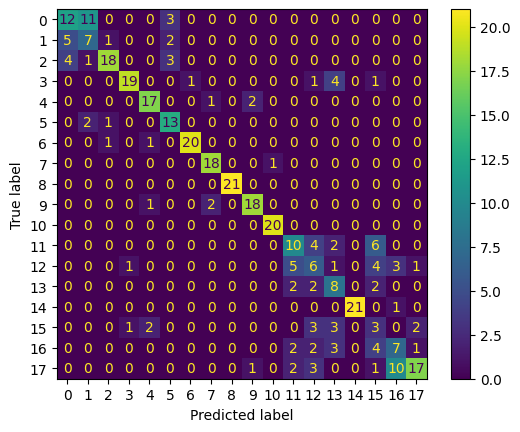

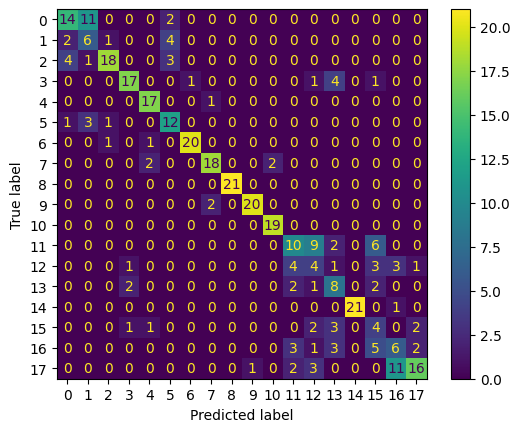

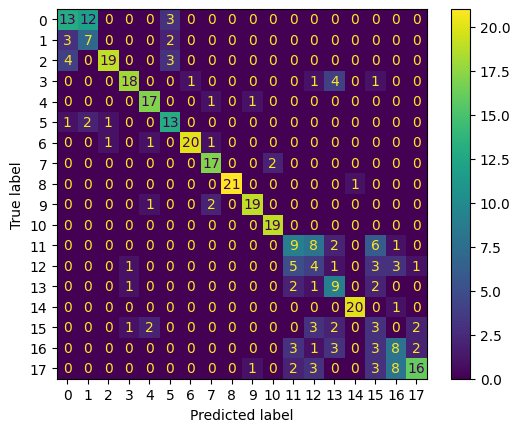

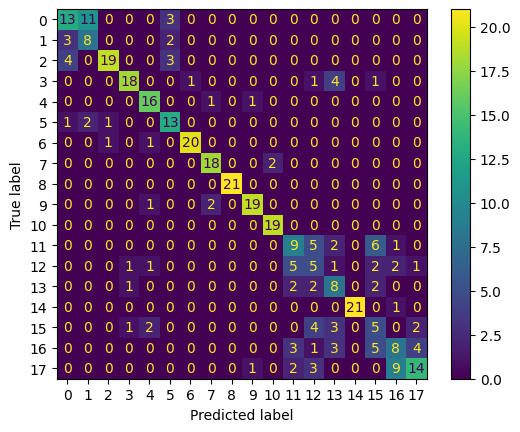

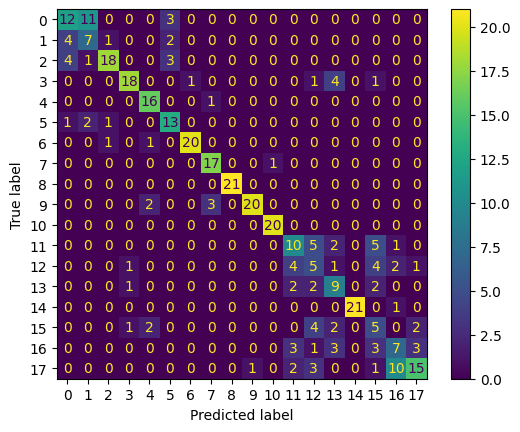

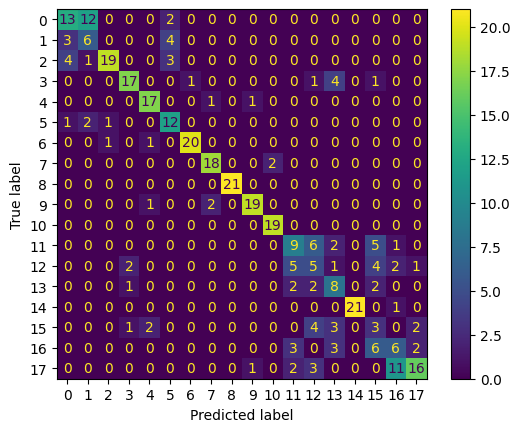

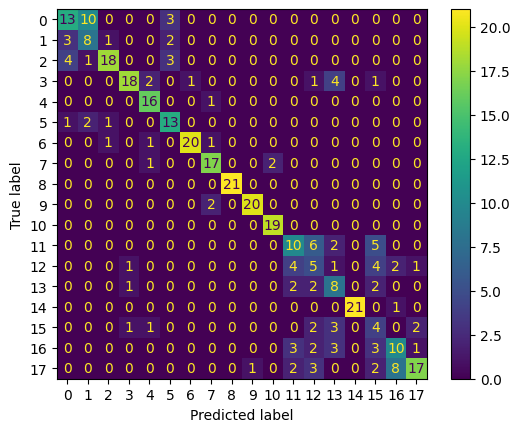

Mean accuracy (1 runs): 0.6698. Mean f1-score: 0.6776.Std accuracy (1 runs): 0.0081. Std f1-score: 0.0082


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


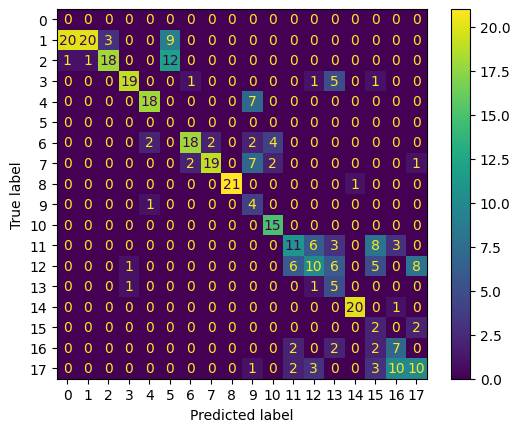

Mean accuracy (1 runs): 0.5741. Mean f1-score: 0.6237.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


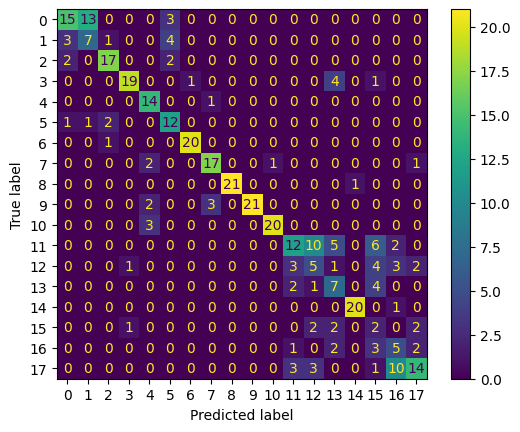

Mean accuracy (1 runs): 0.6561. Mean f1-score: 0.6696.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000
START DIMENSION 9
Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 9
Epoch:1, P:10, Loss:339.3901, Loss-ae:309.8196, Loss-topo:29.5705
Epoch:2, P:10, Loss:293.5886, Loss-ae:278.1933, Loss-topo:15.3953
Epoch:3, P:10, Loss:264.0914, Loss-ae:247.4202, Loss-topo:16.6712
Epoch:4, P:10, Loss:232.9627, Loss-ae:230.1802, Loss-topo:2.7825
Epoch:5, P:10, Loss:235.4813, Loss-ae:230.3245, Loss-topo:5.1568
Epoch:6, P:9, Loss:240.5965, Loss-ae:237.8374, Loss-topo:2.7591
Epoch:7, P:8, Loss:223.9783, Loss-ae:221.1994, Loss-topo:2.7788
Epoch:8, P:10, Loss:223.7472, Loss-ae:221.3591, Loss-topo:2.3880
Epoch:9, P:10, Loss:216.0503, Loss-ae:215.1415, Loss-topo:0.9088
Epoch:10, P:10, Loss:214.4522, Loss-ae:212.1528, Loss-topo:2.2993
Epoch:11, P:10, Loss:227.1603, Loss-ae:221.2869, Loss-topo:5.8734
Epoch:12, P:9, Loss:197.6858

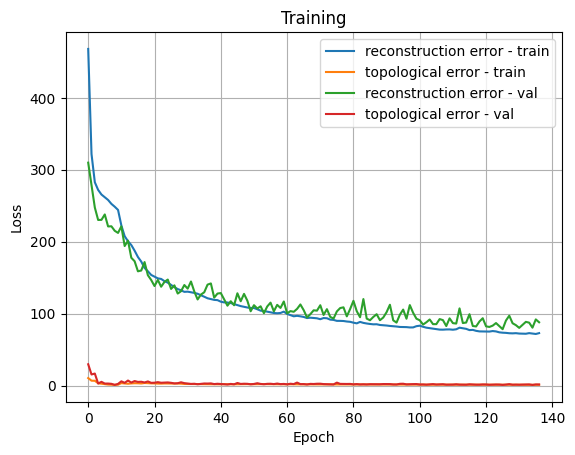

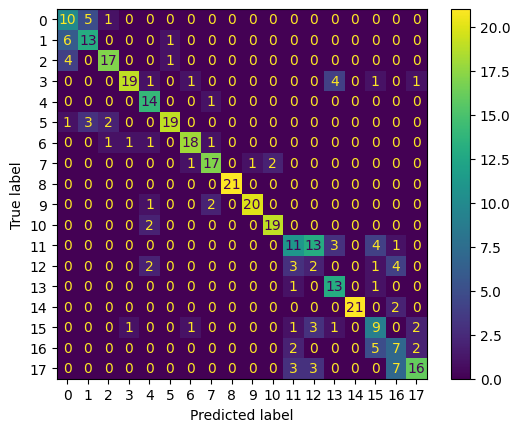

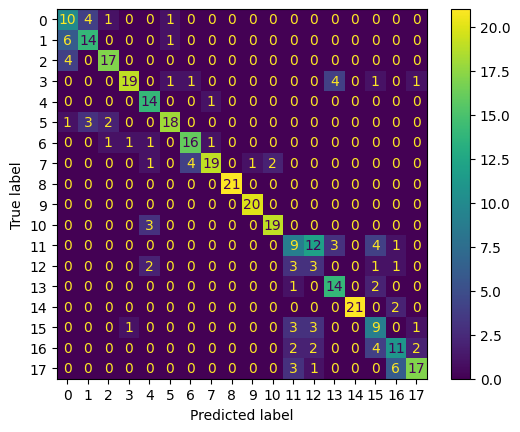

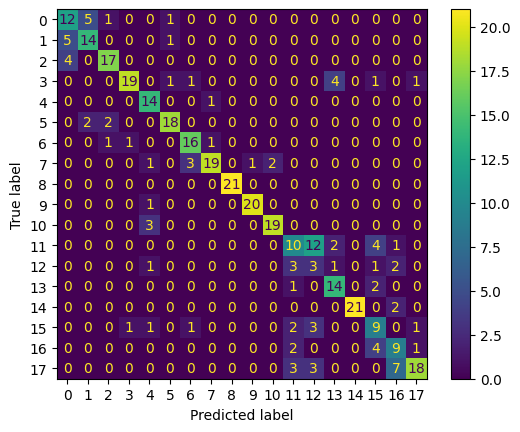

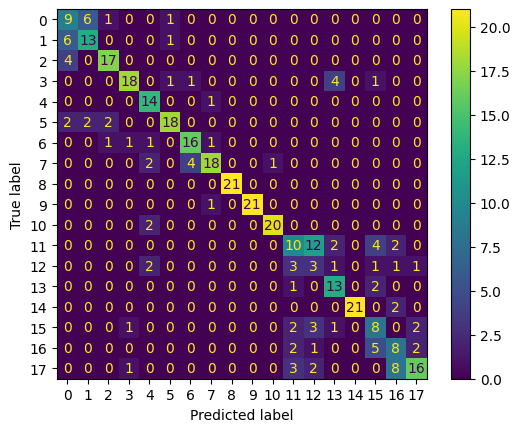

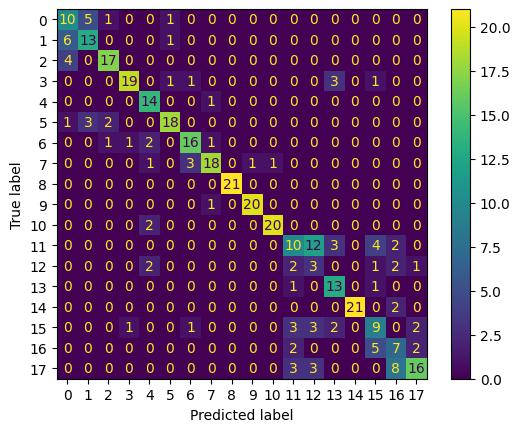

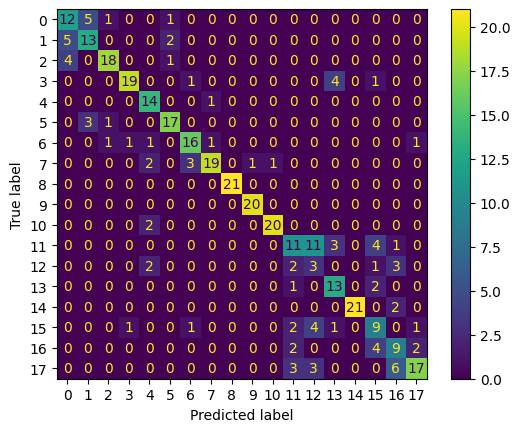

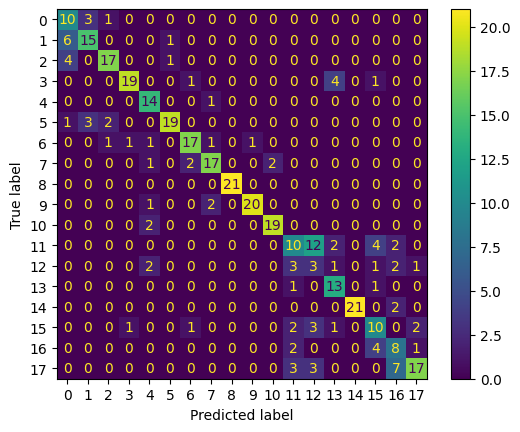

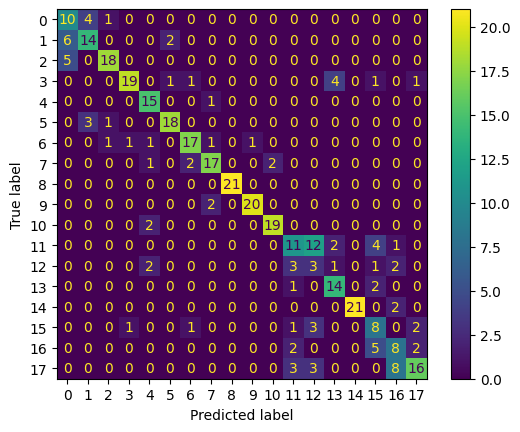

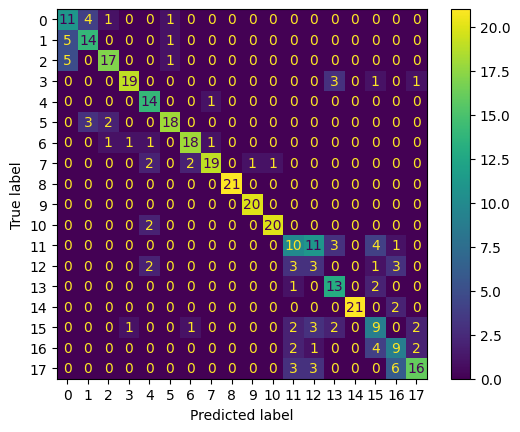

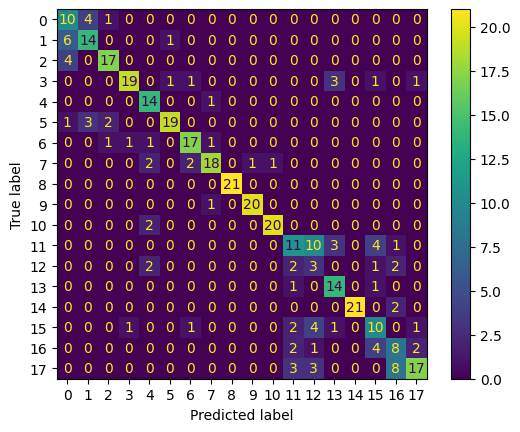

Mean accuracy (1 runs): 0.7130. Mean f1-score: 0.7205.Std accuracy (1 runs): 0.0085. Std f1-score: 0.0086


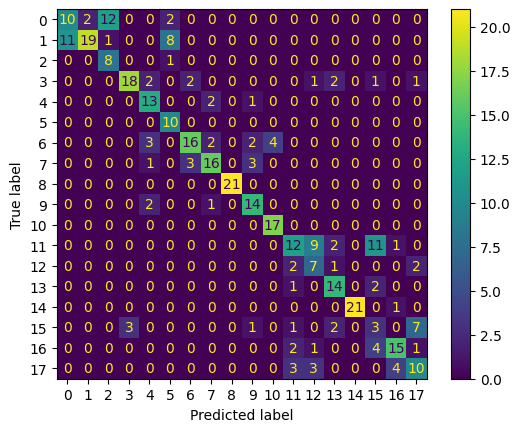

Mean accuracy (1 runs): 0.6455. Mean f1-score: 0.6460.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


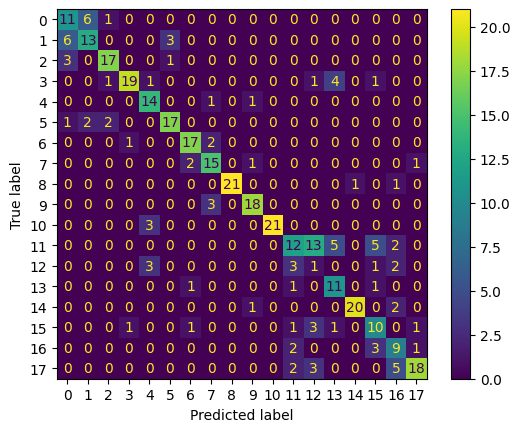

Mean accuracy (1 runs): 0.6984. Mean f1-score: 0.7076.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


In [15]:
for i in dimensions:
    print('START DIMENSION', i)
    transformer_topoae = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2',
                                                          ae_kwargs={'input_dims':180, 'custom_dim':i},
                                                          input_shape=(-1, 1, 180))
    transformer_topoae.fit(train_dataset_fft.X, train_dataset_fft.y)
    topo_models.append(transformer_topoae)
    
    # Applying topological autoencoders to train dataset
    train_dataset_after_topoae_transform = transformer_topoae.transform(train_dataset_fft.X)
    train_dataset_after_topoae_transform = np.reshape(train_dataset_after_topoae_transform, (-1,i))
    lowdim_train_dataset_fft.append(train_dataset_after_topoae_transform)
    
    # Applying topological autoencoders to test dataset
    test_dataset_after_topoae_transform = transformer_topoae.transform(test_dataset_fft.X)
    # print(test_dataset_after_topoae_transform.shape)
    test_dataset_after_topoae_transform = np.reshape(test_dataset_after_topoae_transform, (-1,i))
    lowdim_test_dataset_fft.append(test_dataset_after_topoae_transform)
    
    # Evaluating pyDRMetrics to test dataset
    metrics_reporter = DimensionalityReductionQualityReport(sampling_threshold=378)
    metrics_on_test_dataset = metrics_reporter.evaluate([test_dataset_fft.X, test_dataset_after_topoae_transform])
    
    lowdim_pyDRMetrics_eval.append(metrics_on_test_dataset)
    
    # Evaluating classification metrics to test dataset
    get_classification_metrics(train_dataset_after_topoae_transform,
                               train_dataset_fft.y, 
                               test_dataset_after_topoae_transform,
                               test_dataset_fft.y)
    # lowdim_classification_eval.append() 

In [16]:
criteria = 'trustworthiness'
values = [evaluation[criteria] for evaluation in lowdim_pyDRMetrics_eval]
print(values)

[0.9290680544023748, 0.9208652652152509, 0.9277610821693351, 0.9168231114572695, 0.9366292974863516]


In [17]:
print(lowdim_pyDRMetrics_eval)

[{'residual variance (pearson)': 0.13114939969387862, 'residual variance (spearman)': 0.18158837243260828, 'trustworthiness': 0.9290680544023748, 'continuity': 0.9632876734975789, 'co k nearest neighbor size': 0.48822944297082227, 'local continuity meta criterion': 0.44567625148146056, 'local property': 0.505542001893382, 'global property': 0.8527776933503716}, {'residual variance (pearson)': 0.16739253213640104, 'residual variance (spearman)': 0.19936142740988416, 'trustworthiness': 0.9208652652152509, 'continuity': 0.9595228954348737, 'co k nearest neighbor size': 0.4630305039787798, 'local continuity meta criterion': 0.4204773124894181, 'local property': 0.5514691150452603, 'global property': 0.8747969443963405}, {'residual variance (pearson)': 0.200745971232142, 'residual variance (spearman)': 0.2013020879723746, 'trustworthiness': 0.9277610821693351, 'continuity': 0.9562426063763345, 'co k nearest neighbor size': 0.46501989389920423, 'local continuity meta criterion': 0.4224667024

In [18]:
import matplotlib.pyplot as plt

def plot_criteria(criteria):
    values = [evaluation[criteria] for evaluation in lowdim_pyDRMetrics_eval]
    x = np.array(range(len(dimensions)))
    my_xticks = [str(val) for val in dimensions]
    plt.xticks(x, my_xticks)
    plt.grid()
    plt.plot(values)
    plt.title(criteria + ' over dimensionalities')
    plt.ylabel(criteria + ' - metric value')
    plt.xlabel('dimensionality')
    plt.ylim((0,1))
    plt.show()

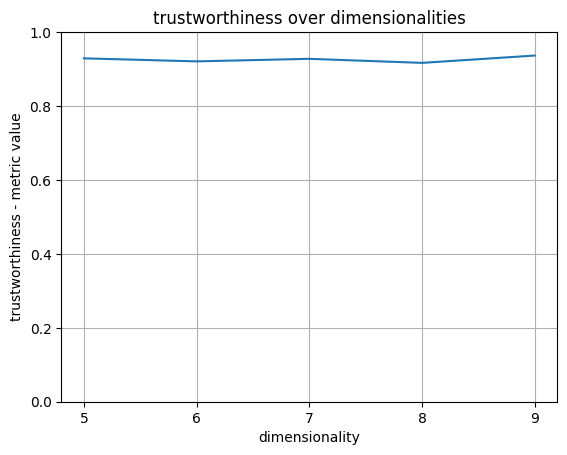

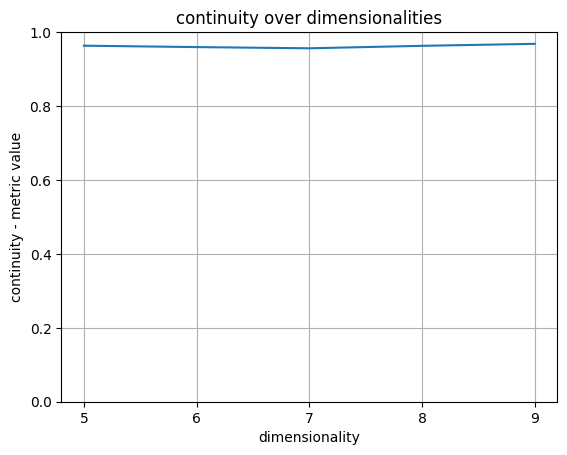

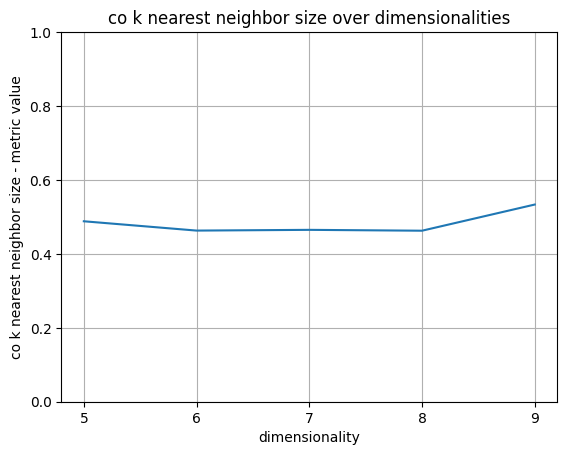

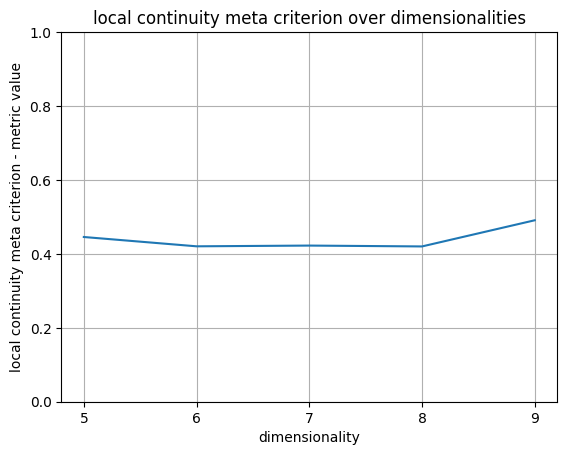

In [19]:
criteria_set = ['trustworthiness', 'continuity', 'co k nearest neighbor size', 'local continuity meta criterion']
for criteria_unit in criteria_set:
    plot_criteria(criteria_unit)

In [20]:
print(lowdim_classification_eval)

[]


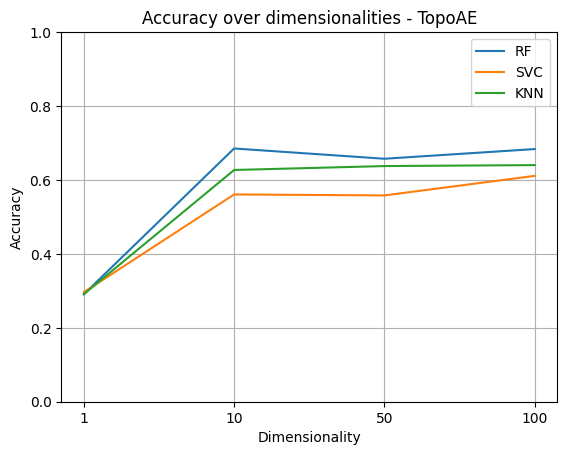

In [22]:
dimensions = [1, 10, 50, 100]
# criteria = 'accuracy'
    
# f1_values_runs = [evaluation['runs'] for evaluation in lowdim_classification_eval]
accuracy_over_dimensions_RF = [0.2907, 0.6852, 0.6574, 0.6836]
accuracy_over_dimensions_SVC = [0.2963, 0.5608, 0.5582, 0.6111]
accuracy_over_dimensions_KNN = [0.2910, 0.6270, 0.6376, 0.6402]
# accuracy_over_dimensions = [accuracy_over_dimensions_RF, accuracy_over_dimensions_SVC, accuracy_over_dimensions_KNN]
# for evaluation in lowdim_classification_eval:
#     runs = evaluation['runs']
#     criteria_set = []
#     for run in runs:
#         criteria_set.append(run['result'][0][criteria])
#         # print('run id', run['run id'])
#         # print(run['result'][0][criteria])
#     accuracy_over_dimensions.append(np.mean(criteria_set))

x = np.array(range(len(dimensions)))
my_xticks = [str(val) for val in dimensions]
plt.xticks(x, my_xticks)
plt.grid()
plt.plot(accuracy_over_dimensions_RF, label='RF')
plt.plot(accuracy_over_dimensions_SVC, label='SVC')
plt.plot(accuracy_over_dimensions_KNN, label='KNN')
plt.title('Accuracy over dimensionalities - TopoAE')
plt.ylabel('Accuracy')
plt.xlabel('Dimensionality')
plt.legend()
plt.ylim((0,1))
plt.show()
    
# print(f1_values_runs)

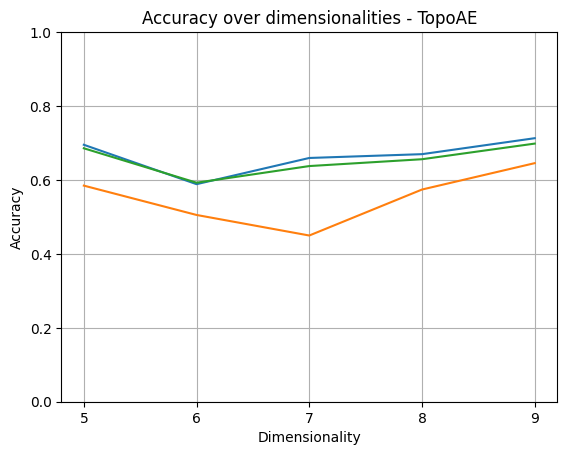

In [23]:
dimensions = [5, 6, 7, 8, 9]
# criteria = 'accuracy'
    
# f1_values_runs = [evaluation['runs'] for evaluation in lowdim_classification_eval]
accuracy_over_dimensions_RF = [0.6952, 0.5886, 0.6595, 0.6698, 0.7130]
accuracy_over_dimensions_SVC = [0.5847, 0.5053, 0.4497, 0.5741, 0.6455]
accuracy_over_dimensions_KNN = [0.6857, 0.5926, 0.6376, 0.6561, 0.6984]
# accuracy_over_dimensions = [accuracy_over_dimensions_RF, accuracy_over_dimensions_SVC, accuracy_over_dimensions_KNN]
# for evaluation in lowdim_classification_eval:
#     runs = evaluation['runs']
#     criteria_set = []
#     for run in runs:
#         criteria_set.append(run['result'][0][criteria])
#         # print('run id', run['run id'])
#         # print(run['result'][0][criteria])
#     accuracy_over_dimensions.append(np.mean(criteria_set))

x = np.array(range(len(dimensions)))
my_xticks = [str(val) for val in dimensions]
plt.xticks(x, my_xticks)
plt.grid()
plt.plot(accuracy_over_dimensions_RF, label='RF')
plt.plot(accuracy_over_dimensions_SVC, label='SVC')
plt.plot(accuracy_over_dimensions_KNN, label='KNN')
plt.title('Accuracy over dimensionalities - TopoAE')
plt.ylabel('Accuracy')
plt.xlabel('Dimensionality')
plt.ylim((0,1))
plt.show()
    
# print(f1_values_runs)